# <ins>U.S. Trademark Smart Search App</ins> by Earnest Long, Jr.

### <i>Goal: Establish the inadequacy of numerical image similarity metrics, then develop a neural method of image similarity that captures human notions of visual similarity.</i>

### Step 1: Calculate numerical similarity between semantically similar images

In [1]:
import numpy as np

import imageio
import matplotlib.pyplot as plt

<b>L1 Norm: Basic Image Similarity Metric</b>

In [2]:
def calc_L1_norm(img1, img2):
    assert img1.shape == img2.shape, 'Images must have the same shape!'
    return (np.sum(np.abs(img1 - img2))) / (img1.shape[0] * img1.shape[1] * img1.shape[2]) #Divide by # of pixels to normalize

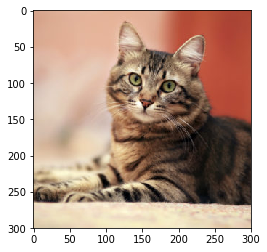

In [3]:
cat1 = imageio.imread('images/cat1.jpg')
plt.imshow(cat1)

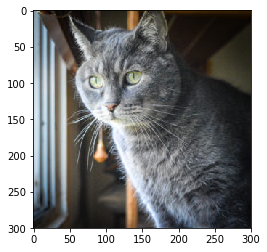

In [4]:
cat2 = imageio.imread('images/cat2.jpg')
plt.imshow(cat2)

In [5]:
print(calc_L1_norm(cat1, cat2)) #Not particularly illuminating.

122.27102592592593


<b>Analysis:</b> 

<i>"Admittedly, the capabilities of simple metrics like L1 and L2 in capturing high-level
image meaning are rather limited. For tasks like semantic content-based image classification, or object recognition under significant transformations, these metrics need to
be augmented with sophisticated representations and, often, statistical classifiers."</i> - http://web.mit.edu/sinhalab/Papers/sinha_russell2011.pdf

The L1 norm for image similarity does not capture semantic similarity, nor does the value it returns have a meaningful human interpretation. This is a problem with all arithmetic metrics for image similarity. Let's try to create a more meaningful determination of similarity.

### Step 2: Define and load the Neural Network Model

We need a better means of quantifying image similarity that makes sense to humans. Let's see what solution neural networks can provide. Since we're borrowing concepts from Neural Style Transfer, we'll use the same model used in the original Neural Style Transfer (NST) paper: https://arxiv.org/abs/1508.06576.

In [6]:
import tensorflow as tf
from nst_utils import *

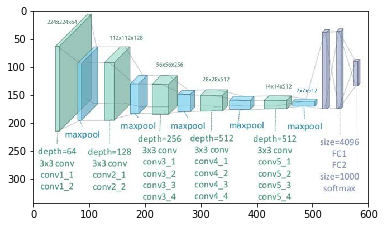

In [7]:
#Visual representation of the VGG-19 model, courtesy of:
#https://www.researchgate.net/figure/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means_fig2_325137356

vgg_img = imageio.imread('images/vgg-19.jpg')
plt.imshow(vgg_img)

In [8]:
#load_vgg_model from nst_utils.py
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

Instructions for updating:
Colocations handled automatically by placer.


<b>Define helper functions:</b>

In [9]:
def load_model():
    return load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [10]:
def half_ceil(x):
    return (np.ceil(x / 2.0)).astype(int)

In [11]:
def half_floor(x):
    return (np.floor(x / 2.0)).astype(int)

In [12]:
#Reshape image file to 300x400 by padding with white space
def pad_to_300_400(img):
    img_xpad = 300 - img.shape[0]
    img_ypad = 400 - img.shape[1]
    img_pad = np.pad(img, ((half_ceil(img_xpad), half_floor(img_xpad)),(half_ceil(img_ypad), half_floor(img_ypad)), (0,0)), 'constant', constant_values=(255,255))
    
    return img_pad

In [13]:
#Image must be 1x300x400x3 to be fed to model
def prep_image_for_model(img):
    #Pad to 300x400
    img_pad = pad_to_300_400(img)
    
    #Further shaping: see nst_utils.py
    img_proc = reshape_and_normalize_image(img_pad)
    
    return img_proc

In [14]:
def convert_to_RGB(img):
    new_img = np.empty([img.shape[0], img.shape[1], 3])
    new_img[:,:,0] = img
    new_img[:,:,1] = img
    new_img[:,:,2] = img
    
    return new_img

In [15]:
def convert_to_grayscale(img):
    new_img = np.copy(img)
    gray_vals = np.sum(img, axis=2) / 3
    new_img[:,:,0] = gray_vals
    new_img[:,:,1] = gray_vals
    new_img[:,:,2] = gray_vals
    
    return new_img

<b>Define test logos for model validation & parameter selection (source: https://lpcreativeco.com/blog/logo-variations-elevate-your-brand/).</b>

Test Logo 1


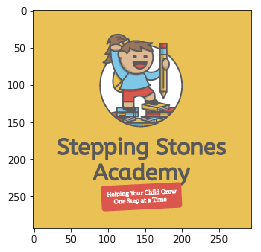

In [16]:
test_logo1 = imageio.imread('images/test_logo1.png')[:,:,:3] #Discard 4th channel (alpha)
plt.imshow(test_logo1)
print("Test Logo 1")

Test Logo 2


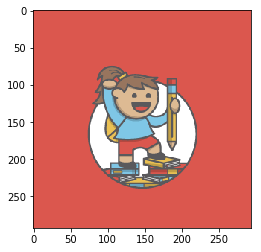

In [17]:
test_logo2 = imageio.imread('images/test_logo2.png')[:,:,:3] #Discard 4th channel (alpha)
plt.imshow(test_logo2)
print("Test Logo 2")

### Step 3a: Calculate "content" similarity

In [18]:
CONTENT_LAYER = 'conv5_2' #See analysis below.

<b>Define helper functions:</b>

In [19]:
def compute_content_cost(a1, a2):
    """
    Computes the content cost
    
    Arguments:
    a1 -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of image 1 
    a1 -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of image 2
    
    Returns: 
    J_content -- scalar representing content cost between image 1 and image 2
    """
    
    # Retrieve dimensions from a2
    m, n_H, n_W, n_C = a2.shape
    
    # Reshape a_I and a_C
    a1_unrolled = np.reshape(a1, [n_H * n_W, n_C])
    a2_unrolled = np.reshape(a2, [n_H * n_W, n_C])
    
    # compute the cost
    J_content = (1.0 / (4 * n_H * n_W * n_C)) * np.sum(np.square(np.subtract(a1_unrolled, a2_unrolled)))
    
    return J_content

In [20]:
#Get the activation of the layer representing the content of the image
def get_content_activation(img, content_layer=CONTENT_LAYER):
    # Reset the graph
    tf.reset_default_graph()

    #Refresh the model
    model = load_model()
    
    with tf.Session() as sess:
        #print(content_layer)
        sess.run(tf.global_variables_initializer())
        
        sess.run(model['input'].assign(img))
        out = model[content_layer]
        a = sess.run(out)

        return a

In [21]:
def get_content_cost(img1, img2, content_layer=CONTENT_LAYER):
    
    #Process images 
    proc_img1 = prep_image_for_model(img1)
    proc_img2 = prep_image_for_model(img2)
    
    #Get activations
    a1 = get_content_activation(proc_img1, content_layer)
    a2 = get_content_activation(proc_img2, content_layer)
    
    return compute_content_cost(a1, a2)

In [22]:
def process_and_get_content_activ(img):
    proc_img = prep_image_for_model(img)
    a = get_content_activation(proc_img)
    
    return a

<b>Test different layers for optimum content layer (LOWER CONTENT COST = MORE SIMILAR!)</b>

In [23]:
#All layers of ConvNet
all_layer_list = ['conv1_1', 'conv1_2',
                  'conv2_1', 'conv2_2',
                  'conv3_1', 'conv3_2', 'conv3_3', 'conv3_4',
                  'conv4_1', 'conv4_2', 'conv4_3', 'conv4_4',
                  'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4']

<b>Calculate each layer's content cost for control pair, Test Logo 1 and Test Logo 2.

- Images are derivatives of one another, meaning that they possess identical literal content, and thus perfect semantic similarity.</b>

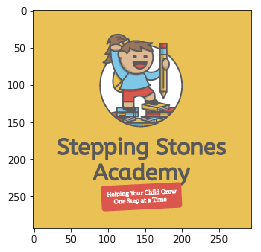

In [24]:
plt.imshow(test_logo1)

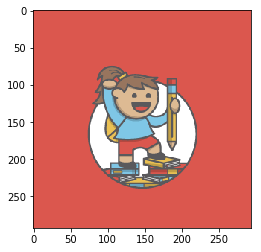

In [25]:
plt.imshow(test_logo2)

In [26]:
test_results1 = []
for idx, c_layer in enumerate(all_layer_list):
    cost = round(get_content_cost(test_logo1, test_logo2, c_layer), 2)
    print('Content cost for layer %s: %.2f' % (all_layer_list[idx], cost))
    test_results1.append(cost)
#'Conv5_4' produces lowest content cost, as expected (see Analysis below).

Content cost for layer conv1_1: 584.27
Content cost for layer conv1_2: 9746.03
Content cost for layer conv2_1: 5525.46
Content cost for layer conv2_2: 12725.06
Content cost for layer conv3_1: 6030.69
Content cost for layer conv3_2: 5487.93
Content cost for layer conv3_3: 10706.19
Content cost for layer conv3_4: 38036.02
Content cost for layer conv4_1: 20504.09
Content cost for layer conv4_2: 15464.54
Content cost for layer conv4_3: 5154.99
Content cost for layer conv4_4: 802.17
Content cost for layer conv5_1: 126.54
Content cost for layer conv5_2: 22.75
Content cost for layer conv5_3: 3.58
Content cost for layer conv5_4: 0.10


<b>Calculate each layer's content cost for similar pair, FI Logo and TestCat.

- Images are not identical in content, but are semantically similar (both have cats and text).</b>

FI Logo


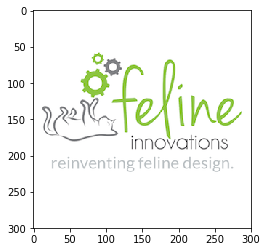

In [27]:
fi_logo = imageio.imread('images/fi_logo_300.png')[:,:,:3] #Discard 4th channel (alpha)
plt.imshow(fi_logo)
print('FI Logo')

<b>Source of Test Cat Logo image below: https://blog.designcrowd.com/article/938/cat-logo-designs-that-work-purrr-fectly-for-their-brand<br>
(Design by Kirsaki: http://www.brandcrowd.com/users/profile/kirsaki)</b>

TestCat Logo


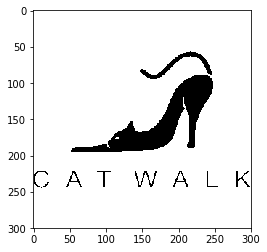

In [28]:
test_logo_cat_raw = imageio.imread('images/test_logo_cat.png') #B/W image (2 channels instead of 3); must convert
test_logo_cat = convert_to_RGB(test_logo_cat_raw)
plt.imshow(test_logo_cat)
print('TestCat Logo')

In [29]:
test_results2 = []
for idx, c_layer in enumerate(all_layer_list):
    cost = round(get_content_cost(fi_logo, test_logo_cat, c_layer), 2)
    #print('Content cost for layer %s: %.2f' % (all_layer_list[idx], cost))
    test_results2.append(cost)

<b>Calculate each layer's content cost for dissimilar pair, FI Logo and Test Logo 1.

- Images are not identical in content, nor are they semantically similar.</b>

In [30]:
test_results3 = []
for idx, c_layer in enumerate(all_layer_list):
    cost = round(get_content_cost(fi_logo, test_logo1, c_layer), 2)
    #print('Content cost for layer %s: %.2f' % (all_layer_list[idx], cost))
    test_results3.append(cost)

In [31]:
import pandas as pd

In [32]:
pd.options.display.max_columns = None

In [33]:
results_table = pd.DataFrame([test_results1, test_results2, test_results3],
                             index=['TL1 vs. TL2', 'FI vs. TestCat', 'FI vs. TL1'],
                             columns=all_layer_list)
display(results_table)

,conv1_1,conv1_2,conv2_1,conv2_2,conv3_1,conv3_2,conv3_3,conv3_4,conv4_1,conv4_2,conv4_3,conv4_4,conv5_1,conv5_2,conv5_3,conv5_4
TL1 vs. TL2,584.27,9746.03,5525.46,12725.06,6030.69,5487.93,10706.19,38036.02,20504.09,15464.54,5154.99,802.17,126.54,22.75,3.58,0.10
FI vs. TestCat,505.63,7067.57,7547.62,15652.19,7239.88,6974.13,13745.79,46720.52,26885.32,19306.44,6862.07,1122.89,152.29,24.33,4.03,0.19
FI vs. TL1,815.71,13223.40,6768.20,17255.33,8082.29,7892.15,16181.33,58084.61,32753.67,24008.24,7675.23,1106.85,177.87,31.68,4.56,0.14


<b>Raw numbers don't mean much - calculate % difference from control pair.</b>

In [34]:
results_table_pct = pd.DataFrame(index=['TL1 vs. TL2', 'FI vs. TestCat', 'FI vs. TL1'],
                             columns=all_layer_list)

In [35]:
results_table_pct.loc['TL1 vs. TL2'] = '--'
results_table_pct.loc['FI vs. TestCat'] = ((results_table.loc['FI vs. TestCat'] - results_table.loc['TL1 vs. TL2']) / results_table.loc['TL1 vs. TL2'] * 100).round(2).astype(str) + '%'
results_table_pct.loc['FI vs. TL1'] = ((results_table.loc['FI vs. TL1'] - results_table.loc['TL1 vs. TL2']) / results_table.loc['TL1 vs. TL2'] * 100).round(2).astype(str) + '%'

In [36]:
display(results_table_pct)

,conv1_1,conv1_2,conv2_1,conv2_2,conv3_1,conv3_2,conv3_3,conv3_4,conv4_1,conv4_2,conv4_3,conv4_4,conv5_1,conv5_2,conv5_3,conv5_4
TL1 vs. TL2,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
FI vs. TestCat,-13.46%,-27.48%,36.6%,23.0%,20.05%,27.08%,28.39%,22.83%,31.12%,24.84%,33.12%,39.98%,20.35%,6.95%,12.57%,90.0%
FI vs. TL1,39.61%,35.68%,22.49%,35.6%,34.02%,43.81%,51.14%,52.71%,59.74%,55.25%,48.89%,37.98%,40.56%,39.25%,27.37%,40.0%


<b>Analysis:</b> In NST, the content cost between the "content" image and the generated image is a function of the difference between the activations for each image of a particular layer of the ConvNet. This layer is traditionally chosen to be one of the later layers of the ConvNet, as successive layers are activated by more complex and complete features of the image. (This is not always the very last layer though... in my previous course, where I first encountered NST, we chose an advanced intermediate layer, 'conv4_2', with great results!)

Because I am seeking the layer parameter that produces the best results based on a human understanding of "content", <i>I choose layer <b>'conv5_2'</b> to be the default CONTENT_LAYER</i>. For 'conv5_2', compared to the test results of the derivative Test Logos (which serve as a control, given that they possess perfect semantic similarity (identical literal content)), the cost of the two cat logos is similar but slightly higher, while the cost of the two different images, one cat logo and one test logo, is significantly higher. The results of 'conv5_2' make the most intuitive sense for this application.

### Step 3b: Calculate "style" similarity

<b>Define helper functions:</b>

In [37]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)] #See analysis below.

In [38]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = np.matmul(A, np.transpose(A))
    
    return GA

In [39]:
def compute_layer_style_cost(a1, a2):
    """
    Arguments:
    a1 -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of image 1 
    a2 -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of image 2
    
    Returns: 
    J_style_layer -- scalar representing style cost between image 1 and image 2
    """
    
    # Retrieve dimensions from a1
    m, n_H, n_W, n_C = a1.shape
    
    # Reshape the images to be of shape (n_C, n_H*n_W)
    a1 = np.transpose(np.reshape(a1, [n_H * n_W, n_C]))
    a2 = np.transpose(np.reshape(a2, [n_H * n_W, n_C]))

    # Computing gram_matrices for both images 1 and 2
    G1 = gram_matrix(a1)
    G2 = gram_matrix(a2)

    # Computing the loss
    J_style_layer = (1.0 / (4 * n_C * n_C * n_H * n_H * n_W * n_W)) * np.sum(np.square(np.subtract(G1, G2)))
    
    return J_style_layer

In [40]:
def sum_layer_style_costs(style_activations_1, style_activations_2,
                          style_layers=STYLE_LAYERS,
                          report_all_costs=False):
    assert len(style_activations_1) == len(style_activations_2)
    all_costs = []
    
    total_style_cost = 0
    
    for i, activation in enumerate(style_activations_1):
        _, coeff = style_layers[i]
        style_cost = compute_layer_style_cost(style_activations_1[i], style_activations_2[i])
        #print('Style cost for layer %i: %.2f' % (i+1, style_cost))
        all_costs.append(style_cost)
        
        total_style_cost += (coeff * style_cost)
    
    all_costs.append(total_style_cost)
    
    if (report_all_costs):
        return all_costs
    else:
        return total_style_cost

In [41]:
def get_style_activations(img, style_layers=STYLE_LAYERS):
    # Reset the graph
    tf.reset_default_graph()

    #Reload the model
    model = load_model()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        sess.run(model['input'].assign(img))
        style_activations = []

        for layer_name, _ in style_layers:
            out = model[layer_name]
            style_activations.append(sess.run(out))

        return style_activations

In [42]:
def get_style_cost(img1, img2, style_layers=STYLE_LAYERS, report_all_costs=False):
    
    #Process images 
    proc_img1 = prep_image_for_model(img1)
    proc_img2 = prep_image_for_model(img2)
    
    #Get activations
    a1 = get_style_activations(proc_img1, style_layers)
    a2 = get_style_activations(proc_img2, style_layers)
    
    return sum_layer_style_costs(a1, a2, style_layers, report_all_costs)

In [43]:
def process_and_get_style_activs(img):
    proc_img = prep_image_for_model(img)
    a = get_style_activations(proc_img)
    
    return a

<b>Compare paintings by same artist (Claude Monet) to benchmark style scores.</b>

Monet 1


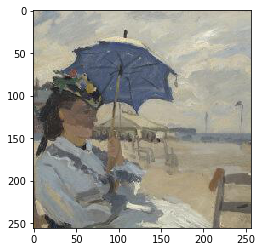

In [44]:
monet1 = imageio.imread('https://www.nationalgallery.org.uk/server.iip?FIF=/fronts/N-3951-00-000022-WZ-PYR.tif&CNT=1&JTL=1,0')
plt.imshow(monet1)
print('Monet 1')

Monet 2


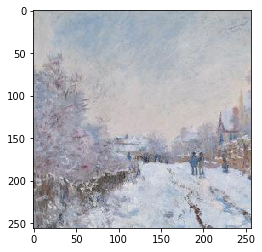

In [45]:
monet2 = imageio.imread('https://www.nationalgallery.org.uk/server.iip?FIF=/fronts/N-6607-00-000013-WZ-PYR.tif&CNT=1&JTL=1,0')
plt.imshow(monet2)
print('Monet 2')

Monet 3


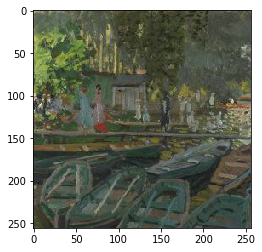

In [46]:
monet3 = imageio.imread('https://www.nationalgallery.org.uk/server.iip?FIF=/fronts/N-6456-00-000031-WZ-PYR.tif&CNT=1&JTL=1,0')
plt.imshow(monet3)
print('Monet 3')

Monet 4


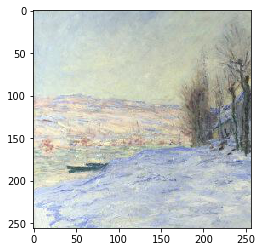

In [47]:
monet4 = imageio.imread('https://www.nationalgallery.org.uk/server.iip?FIF=/fronts/N-3262-00-000022-WZ-PYR.tif&CNT=1&JTL=1,0')
plt.imshow(monet4)
print('Monet 4')

Monet 5


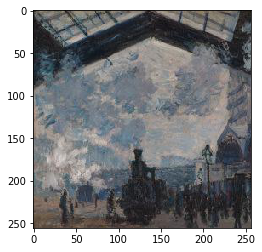

In [48]:
monet5 = imageio.imread('https://www.nationalgallery.org.uk/server.iip?FIF=/fronts/N-6479-00-000032-WZ-PYR.tif&CNT=1&JTL=1,0')
plt.imshow(monet5)
print('Monet 5')

Monet 6


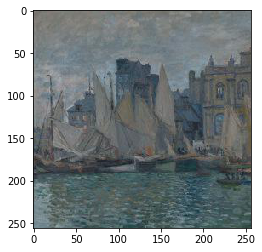

In [49]:
monet6 = imageio.imread('https://www.nationalgallery.org.uk/server.iip?FIF=/fronts/N-6527-00-000020-WZ-PYR.tif&CNT=1&JTL=1,0')
plt.imshow(monet6)
print('Monet 6')

In [50]:
print('Comparing monet1 with monet2')
print('Content cost: %f' % get_content_cost(monet1, monet2))
print('Style cost: %f' % get_style_cost(monet1, monet2))

Comparing monet1 with monet2
Content cost: 9.422418
Style cost: 6574595.879490


In [51]:
print('Comparing monet1 with monet3')
print('Content cost: %f' % get_content_cost(monet1, monet3))
print('Style cost: %f' % get_style_cost(monet1, monet3))

Comparing monet1 with monet3
Content cost: 10.378363
Style cost: 6886482.599893


In [52]:
print('Comparing monet2 with monet4')
print('Content cost: %f' % get_content_cost(monet2, monet4))
print('Style cost: %f' % get_style_cost(monet2, monet4))

Comparing monet2 with monet4
Content cost: 7.453885
Style cost: 5473971.716003


In [53]:
print('Comparing monet4 with monet5')
print('Content cost: %f' % get_content_cost(monet4, monet5))
print('Style cost: %f' % get_style_cost(monet4, monet5))

Comparing monet4 with monet5
Content cost: 13.028703
Style cost: 16490055.217014


In [54]:
print('Comparing monet4 with monet6')
print('Content cost: %f' % get_content_cost(monet4, monet6))
print('Style cost: %f' % get_style_cost(monet4, monet6))

Comparing monet4 with monet6
Content cost: 9.131981
Style cost: 10579066.412256


In [55]:
print('Comparing monet5 and monet6')
print('Content cost: %f' % get_content_cost(monet5, monet6))
print('Style cost: %f' % get_style_cost(monet5, monet6))

Comparing monet5 and monet6
Content cost: 12.889205
Style cost: 7475954.335653


<b>Notes:</b>
-  Monet paintings 2 and 4 seem most visually similar to the eye in both content & style
    -  And indeed, have both lowest content and style costs
-  Unsure why paintings 5 and 6 are judged as so dissimilar in style to painting 4...
    -  Could be darkness of color scheme rather than brush style

<b>Test different sets of layers for optimum style layer set (LOWER STYLE COST = MORE SIMILAR!)</b>

In [56]:
#Second element of each tuple, the coefficient (here, 0.2), represents each layer's weight in layer set,
#where weight = proportional contribution to total style cost.
s_layers1 = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]
s_layers2 = [
    ('conv1_2', 0.2),
    ('conv2_2', 0.2),
    ('conv3_2', 0.2),
    ('conv4_2', 0.2),
    ('conv5_2', 0.2)]
s_layers3 = [
    ('conv1_2', 0.2),
    ('conv2_2', 0.2),
    ('conv3_3', 0.2),
    ('conv4_3', 0.2),
    ('conv5_3', 0.2)]
s_layers4 = [
    ('conv1_2', 0.2),
    ('conv2_2', 0.2),
    ('conv3_4', 0.2),
    ('conv4_4', 0.2),
    ('conv5_4', 0.2)]
s_layers_list = [s_layers1, s_layers2, s_layers3, s_layers4]

<b>Calculate each layer set's style cost for control pair, Test Logo 1 and Test Logo 2.

- Images are derivatives of one another, meaning that they possess identical style.</b>

In [57]:
s_test_results1 = []
for idx, s_layers in enumerate(s_layers_list):
    costs = np.round(get_style_cost(test_logo1, test_logo2, s_layers, report_all_costs=True), 2)
    cost_string = ['{:.2f}'.format(x) for x in costs]
    #print(cost_string)
    print('Style costs for layer set %i: %s, %s, %s, %s, %s; Total: %s' % ((idx + 1,) + tuple(cost_string)))
    s_test_results1.append(costs)

Style costs for layer set 1: 921086.76, 13867187.16, 8673142.43, 468363432.35, 4178.00; Total: 98365805.34
Style costs for layer set 2: 399594900.04, 19140490.74, 9047492.97, 156770842.19, 126.40; Total: 116910770.47
Style costs for layer set 3: 399594900.04, 19140490.74, 76530695.58, 6499354.06, 3.41; Total: 100353088.76
Style costs for layer set 4: 399594900.04, 19140490.74, 867309508.50, 45626.15, 0.01; Total: 257218105.09


<b>Calculate each layer set's style cost for similar pair, Monet1 and Monet2.

- Images are not identical in style, but represent the same painting style by the same artist, so very similar.</b>

In [58]:
s_test_results2 = []
for idx, s_layers in enumerate(s_layers_list):
    costs = np.round(get_style_cost(monet1, monet2, s_layers, report_all_costs=True), 2)
    cost_string = ['{:.2f}'.format(x) for x in costs]
    #print(cost_string)
    #print('Style costs for layer set %i: %s, %s, %s, %s, %s; Total: %s' % ((idx + 1,) + tuple(cost_string)))
    s_test_results2.append(costs)

<b>Calculate each layer set's style cost for dissimilar pair, FI Logo and Monet1.

- Images are not identical in style, nor are they stylistically similar.</b>

In [59]:
s_test_results3 = []
for idx, s_layers in enumerate(s_layers_list):
    costs = np.round(get_style_cost(monet1, fi_logo, s_layers, report_all_costs=True), 2)
    cost_string = ['{:.2f}'.format(x) for x in costs]
    #print(cost_string)
    #print('Style costs for layer set %i: %s, %s, %s, %s, %s; Total: %s' % ((idx + 1,) + tuple(cost_string)))
    s_test_results3.append(costs)

In [60]:
#Create single list of layer names (+ total) for dataframe columns
s_columns = []
for i, s_layers in enumerate(s_layers_list):
    for j, s_layer in enumerate(s_layers):
        layer, _ = s_layer
        s_columns.append(layer)
        if (j == len(s_layers) - 1):
            s_columns.append('Total for layer set %i' % (i+1))

In [61]:
results_table = pd.DataFrame([np.array(s_test_results1).flatten(), 
                              np.array(s_test_results2).flatten(), 
                              np.array(s_test_results3).flatten()],
                             index=['TL1 vs. TL2', 'Monet1 vs. Monet2', 'FI vs. Monet1'],
                             columns=s_columns)
#display(results_table)

In [62]:
results_table_pct = pd.DataFrame(index=['TL1 vs. TL2', 'Monet1 vs. Monet2', 'FI vs. Monet1'],
                             columns=s_columns)

In [63]:
results_table_pct.loc['TL1 vs. TL2'] = '--'
results_table_pct.loc['Monet1 vs. Monet2'] = ((results_table.loc['Monet1 vs. Monet2'] - results_table.loc['TL1 vs. TL2']) / results_table.loc['TL1 vs. TL2'] * 100).round(2).astype(str) + '%'
results_table_pct.loc['FI vs. Monet1'] = ((results_table.loc['FI vs. Monet1'] - results_table.loc['TL1 vs. TL2']) / results_table.loc['TL1 vs. TL2'] * 100).round(2).astype(str) + '%'

In [64]:
display(results_table_pct)

,conv1_1,conv2_1,conv3_1,conv4_1,conv5_1,Total for layer set 1,conv1_2,conv2_2,conv3_2,conv4_2,conv5_2,Total for layer set 2,conv1_2,conv2_2,conv3_3,conv4_3,conv5_3,Total for layer set 3,conv1_2,conv2_2,conv3_4,conv4_4,conv5_4,Total for layer set 4
TL1 vs. TL2,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
Monet1 vs. Monet2,-95.23%,-95.64%,-96.63%,-93.18%,-86.53%,-93.32%,-95.63%,-94.28%,-93.77%,-93.75%,-83.5%,-95.06%,-95.63%,-94.28%,-91.36%,-88.99%,-77.71%,-94.84%,-95.63%,-94.28%,-92.25%,-84.73%,-100.0%,-93.33%
FI vs. Monet1,1.92%,65.64%,80.5%,136.76%,103.02%,133.51%,-13.77%,293.02%,161.35%,69.3%,56.75%,21.26%,-13.77%,293.02%,202.36%,95.67%,13.78%,32.31%,-13.77%,293.02%,100.73%,158.83%,0.0%,68.02%


<b>Analysis:</b> In NST, the style cost between the "style" image and the generated image is a function of the difference between the activations for each image across a set of layers spaced throughout the ConvNet. The intuition behind this is that the "style" of an image is what is maintained throughout the layers of a ConvNet (i.e. at varying levels of representational complexity).

Because I am seeking the set of layers that produces the best results based on a human understanding of "style", <i>I choose <b>Layer Set 1</b> to be the default STYLE_LAYERS</i>. For Layer Set 1, compared to the test results of the derivative Test Logos, the cost of the two Monet paintings is (surprisingly!) much smaller, while the cost of the two different images, one cat logo and one Monet, is significantly higher. (The smaller style cost of the Monet paintings compared to the two Test Logos is likely due to the presence of text in one and absence of text in the other.) This makes Layer Set 1 the intuitive choice for this application.

I could break symmetry and choose unevenly "spaced" layers for the default layer set (e.g. 'conv1_1', 'conv2_2', 'conv3_4',... instead of 'conv1_1', 'conv2_1', 'conv3_1',...), but the even spacing likely corresponds to a more robust notion of style. I have also chosen to weight each layer evenly, with a coefficient of 0.2 for each, for the same reason.

### Step 4: Explore the USPTO Trademark Search API

Understand the data accessible by the USPTO Trademark Search API and the format of that data.

- https://developer.uspto.gov/ibd-api-docs/ - GET /v1/trademark/documents

In [65]:
import requests
import json

In [66]:
VERIFY_CERT = False
#This API request throws an SSLError now, where it didn't before... Solution pending.
#DO NOT SET TO FALSE FOR PRODUCTION CODE

In [67]:
r = requests.get('https://developer.uspto.gov/ibd-api/v1/trademark/documents?text=cat%20three%20gears&classCode=020&start=0&rows=10', verify=VERIFY_CERT)

/Users/macuser/miniconda2/lib/python2.7/site-packages/requests/packages/urllib3/connectionpool.py:838: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/security.html
  InsecureRequestWarning)


In [68]:
#Explore the JSON response
resp = r.json()
#print(resp)

<b>Define helper functions:</b>

In [69]:
import urllib

In [70]:
def fetch_tm_json(keywords, class_code, verify_cert=VERIFY_CERT): #(Class code narrows down results to specific product category)
    r = requests.get('https://developer.uspto.gov/ibd-api/v1/trademark/documents?text=%s&classCode=%s&start=0&rows=50' % (urllib.quote(keywords), class_code), verify=verify_cert)
    return r.json()

In [71]:
def get_serial_nos(json_resp):
    json_list = json_resp['response']['docs']
    serial_nos = []
    for i, app in enumerate(json_list):
        cfh = app['uspto_tm_document']['trademark_case_files']['trademark_case_file']['case_file_header']
        if 'design_mark' in cfh['mark'].keys():
            #print(i)
            if 'serial_number' in cfh.keys(): #Some apps don't have serial numbers?
                serial_nos.append(cfh['serial_number'])
    return serial_nos

In [72]:
#Retrieve design mark image file from USPTO database by serial number
def getImageFromSerialNo(serial_no):
    img_url = 'https://tsdr.uspto.gov/img/%s/large' % str(serial_no)
    return imageio.imread(img_url)

### Step 5: Assemble the search app

<b>Define a single composite metric / score for result rankings.</b>

In [73]:
def get_composite_score(content_score, style_score):
    COMP_CONTENT_FACTOR = 1.0
    COMP_STYLE_FACTOR = 1.0
    #Weight content and style evenly to ensure results that score highly in either category are near the top
    
    return ((COMP_CONTENT_FACTOR * content_score) + (COMP_STYLE_FACTOR * style_score))

<b>Define the master algorithm for retrieving results from the API, comparing images, and returning results in order.</b>

In [85]:
def find_results_and_rank(keywords, class_code, img):
    json_resp = fetch_tm_json(keywords, class_code)
    serial_nos = get_serial_nos(json_resp)
    print('Number of results: %s' % str(len(serial_nos)))
    
    #Process user image and retrieve activations
    user_content_activ = process_and_get_content_activ(img)
    user_style_activs = process_and_get_style_activs(img)
    
    #Iterate serial nos, retrieve images, retrieve activations, compute scores
    tm_imgs = []
    score_dict = {}
    
    #Choose factors such that, once calculated, each score is on order of 1-100
    CONTENT_FACTOR = 100
    STYLE_FACTOR = 100000000
    
    for i, serial_no in enumerate(serial_nos):
        
        tm_url = 'https://tsdr.uspto.gov/img/%s/large' % str(serial_no)
        tm_img = imageio.imread(tm_url)
        tm_imgs.append(tm_img)
        
        score_dict[i] = {}
        
        #Process trademark image and retrieve activations
        content_activ = process_and_get_content_activ(tm_img)
        style_activs = process_and_get_style_activs(tm_img)
        
        #Calculate costs
        content_cost = compute_content_cost(user_content_activ, content_activ)
        style_cost = sum_layer_style_costs(user_style_activs, style_activs)
        
        #Take the reciprocal of costs so that HIGHER SCORES = MORE SIMILAR!
        content_score = (1.0 / content_cost) * CONTENT_FACTOR
        style_score = (1.0 / style_cost) * STYLE_FACTOR
        
        score_dict[i]['content_score'] = round(content_score, 2)
        score_dict[i]['style_score'] = round(style_score, 2)
        
        composite_score = get_composite_score(content_score, style_score)
        
        score_dict[i]['composite_score'] = round(composite_score, 2)
        score_dict[i]['image'] = tm_img
    
    #print(score_dict)
    #print(score_dict.items())
    
    return sorted(score_dict.items(), key=lambda kv: kv[1]['composite_score'], reverse=True)

### Step 6: Test the app

<b>Run the algorithm with the FI Logo image as an input and the keyword descriptors 'cat', 'three', and 'gears'. Highest ranking result should be the original Feline Innovations registered trademark logo (same image in B/W, minus the tagline).</b>

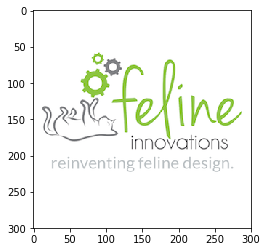

In [75]:
plt.imshow(fi_logo) #Input image

In [87]:
fi_results = find_results_and_rank('cat three gears', '020', fi_logo)

/Users/macuser/miniconda2/lib/python2.7/site-packages/requests/packages/urllib3/connectionpool.py:838: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/security.html
  InsecureRequestWarning)


Number of results: 13


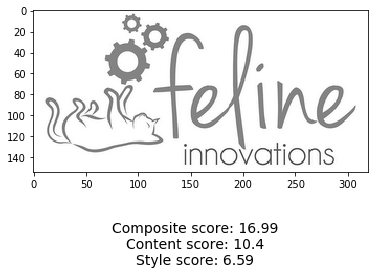

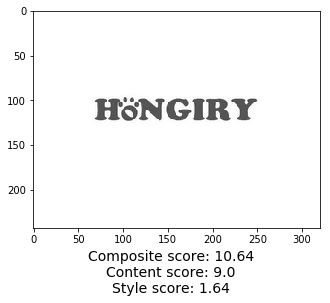

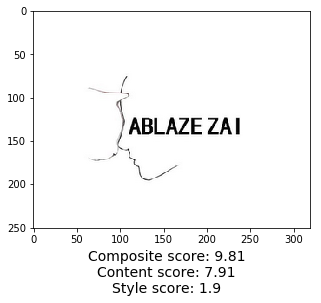

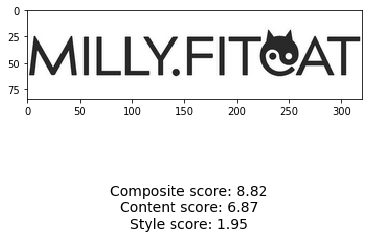

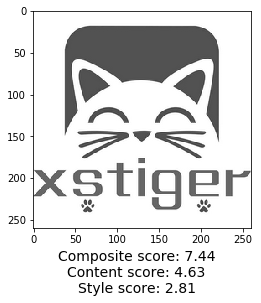

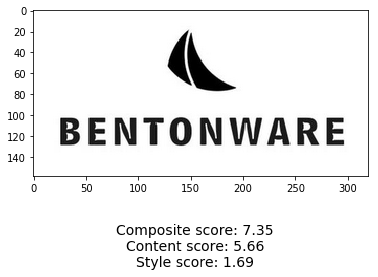

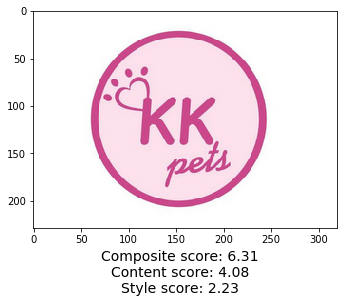

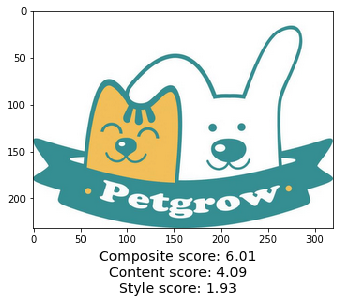

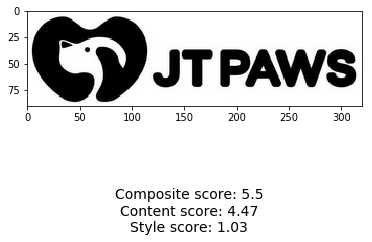

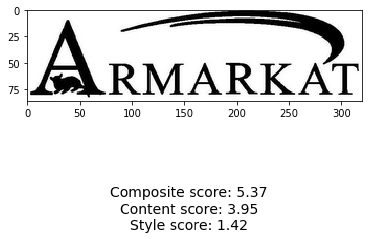

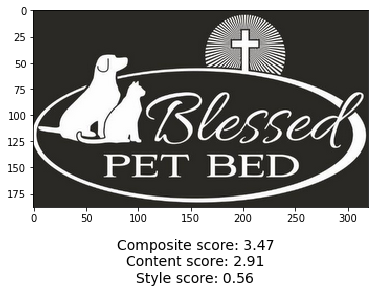

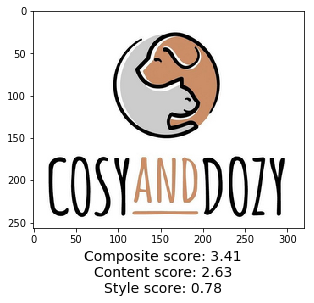

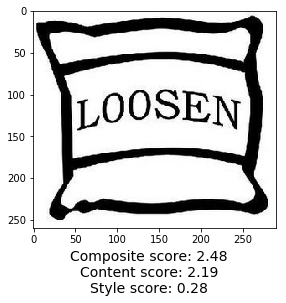

In [88]:
for entry in fi_results:
    _, score_dict = entry
    fig = plt.figure()
    plt.imshow(score_dict['image'])
    txt = 'Composite score: %s\nContent score: %s\nStyle score: %s' % (score_dict['composite_score'], score_dict['content_score'], score_dict['style_score'])
    fig.text(.5, -0.1, txt, ha='center', fontsize=14)
    #print('Composite score: %s' % score_dict['composite_score'])
    #print('Content cost: %s' % score_dict['content_score'])
    #print('Style score: %s' % score_dict['style_score'])

<b>Analysis:</b> <i>The top result, as hoped for and expected, is the registered design mark off which the fi_logo image is based.</i> Why it does not score more highly in the content department compared to the next result, though, is not well understood. Upon inspection, though, the fi_logo.png image contains an extra tagline below the main logo, so the additional text is likely a factor.

Note: As commented above, the content and style <u>scores</u> are calculated as a function of the <i>reciprocal</i> of the <u>costs</u>, so that <b>higher scores indicate greater similarity</b>!

<b>Further research:</b>
-  More testing for optimum content and style layer selection
-  Explore effect of color on content/style costs
-  Consider alternative means of weighting content and style scores
-  <b>Workaround for needing to provide descriptive search terms for API (purely visual search!)</b>

### Addendum

Upon further inspection, based on the observed content and style scores, result rankings should be far more heavily weighted towards "style" than "content"... Let's determine a composite score that returns the results in an order that would be more preferable to a user.

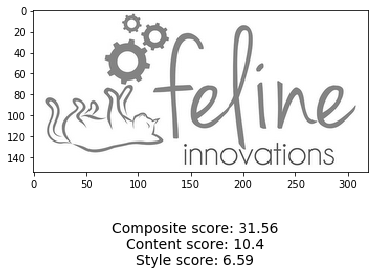

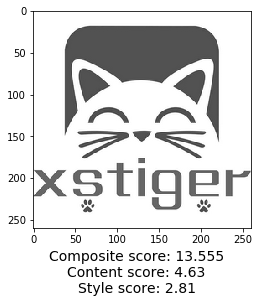

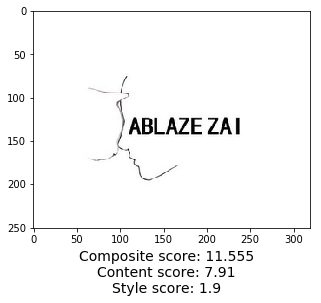

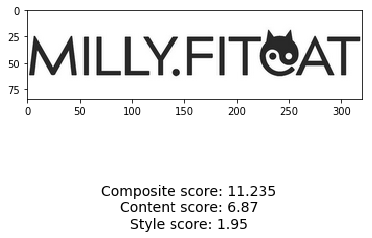

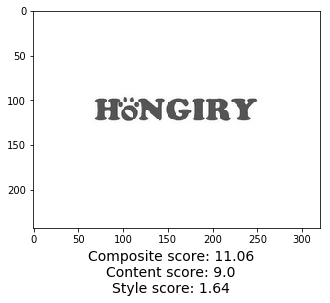

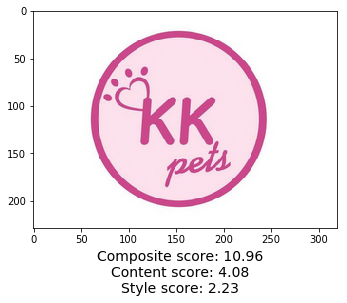

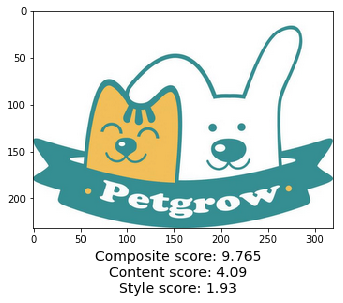

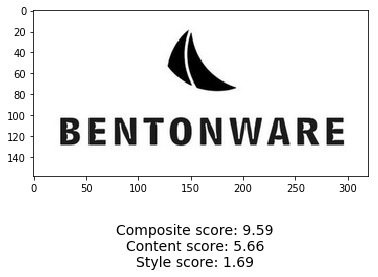

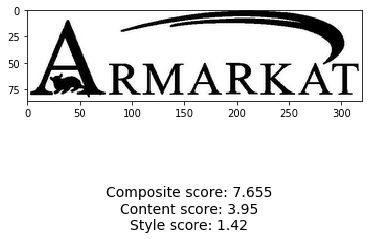

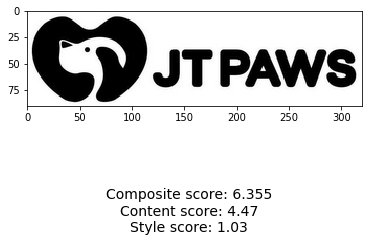

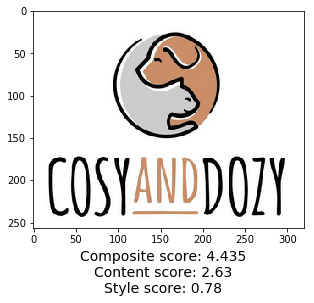

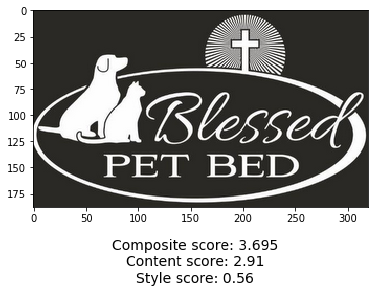

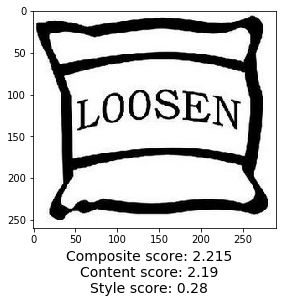

In [89]:
new_fi_results = []
for i, entry in enumerate(fi_results):
    new_fi_results.append(entry)
    #Assign new composite score = 1/2 * content_score + 5 * style_score
    new_fi_results[i][1]['composite_score'] = (new_fi_results[i][1]['content_score'] * 0.5) + (new_fi_results[i][1]['style_score'] * 4)

new_fi_results.sort(key=lambda x: x[1]['composite_score'], reverse=True)

for entry in new_fi_results:
    _, score_dict = entry
    fig = plt.figure()
    plt.imshow(score_dict['image'])
    txt = 'Composite score: %s\nContent score: %s\nStyle score: %s' % (score_dict['composite_score'], score_dict['content_score'], score_dict['style_score'])
    fig.text(.5, -0.1, txt, ha='center', fontsize=14)

<b>Result:</b> A user searching for most similar logos would likely prefer this ordering of results to the previous one. <i>Thus, COMP_CONTENT_FACTOR = 0.5 and COMP_STYLE_FACTOR = 5.0 would be better choices for this application.</i>